In [1]:
#importing necessary libraries
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')
import scipy
from scipy.stats import entropy
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score,f1_score,classification_report
from sklearn import preprocessing
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
import xgboost as xgb
import catboost as cb
import lightgbm as lgbm
from sklearn.preprocessing import StandardScaler
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
import plotly.express as px
import plotly.graph_objects as go
import optuna

In [2]:
set1 = pd.read_csv("./set1_timefeatures.csv") #Reading the data again

In [3]:
#Changing indexing column to time which is also name of the each file
set1 = set1.rename(columns={'Unnamed: 0':'time'})
set1.set_index('time')
set1.describe()
set1.head()

,time,B1_x_mean,B1_x_std,B1_x_skew,B1_x_kurtosis,B1_x_entropy,B1_x_rms,B1_x_max,B1_x_p2p,B1_x_crest,...,B4_y_skew,B4_y_kurtosis,B4_y_entropy,B4_y_rms,B4_y_max,B4_y_p2p,B4_y_crest,B4_y_clearence,B4_y_shape,B4_y_impulse
0,2003-10-22 12:06:24,0.104148,0.081124,-0.029900,1.069800,4.803057,0.124617,0.720,1.108,5.777714,...,0.008208,1.808719,4.690580,0.115266,0.471,0.845,4.086202,0.089551,1.158299,4.733045
1,2003-10-22 12:09:13,0.103651,0.079519,-0.070118,1.161960,4.844846,0.123812,0.654,1.042,5.282223,...,-0.053721,1.873845,4.666142,0.109210,0.627,0.900,5.741234,0.083762,1.166936,6.699653
2,2003-10-22 12:14:13,0.105039,0.080220,-0.041579,0.986724,4.889311,0.125249,0.623,0.940,4.974097,...,0.047069,1.430242,4.681037,0.113695,0.601,0.977,5.286066,0.088436,1.156631,6.114027
3,2003-10-22 12:19:13,0.104900,0.080828,0.005235,1.034758,4.852691,0.125200,0.598,1.055,4.776357,...,0.021169,1.378689,4.696194,0.114415,0.525,0.852,4.588565,0.088515,1.160373,5.324447
4,2003-10-22 12:24:13,0.104779,0.082038,-0.060123,1.110658,4.889993,0.125621,0.623,1.011,4.959370,...,0.008713,1.498303,4.693572,0.114260,0.522,0.871,4.568532,0.088455,1.160343,5.301063


Health Status labels are added according to following dictionary

In [5]:
B1 ={
    "no_failure" : ["2003-10-22 12:06:24" , "2003-10-23 09:14:13",
                    "2003-10-23 09:24:13" , "2003-11-08 12:11:44",
                    "2003-11-08 12:21:44" , "2003-11-19 21:06:07",
                    "2003-11-19 21:16:07" , "2003-11-24 20:47:32"],
    "failure" : ["2003-11-24 20:57:32","2003-11-25 23:39:56"]
}
B2 = {
    "no_failure" : ["2003-10-22 12:06:24" , "2003-11-01 21:41:44",
                    "2003-11-01 21:51:44" , "2003-11-24 01:01:24",
                    "2003-11-24 01:11:24" , "2003-11-25 10:47:32"],
    "failure" : ["2003-11-25 10:57:32" , "2003-11-25 23:39:56"]
}

B3 = {
    "no_failure" : ["2003-10-22 12:06:24" , "2003-11-01 21:41:44",
                    "2003-11-01 21:51:44" , "2003-11-22 09:16:56",
                    "2003-11-22 09:26:56" , "2003-11-25 10:47:32"],
    "failure" : ["2003-11-25 10:57:32" , "2003-11-25 23:39:56"]
}

B4 = {
    "no_failure" : ["2003-10-22 12:06:24" , "2003-10-29 21:39:46",
                    "2003-10-29 21:49:46" , "2003-11-15 05:08:46",
                    "2003-11-15 05:18:46" , "2003-11-18 19:12:30"],
    "failure" : ["2003-11-19 09:06:09" , "2003-11-22 17:36:56",
                 "2003-11-22 17:46:56" , "2003-11-25 23:39:56"]
}

In [6]:
B1_state = list()
B2_state = list()
B3_state = list()
B4_state = list()
cnt = 0

for row in set1["time"]:
    cnt += 1
    # B1
    if cnt<=2098:
        B1_state.append("no_failure")
    if 2098 < cnt <= 2156:
        B1_state.append("failure")
    #B2
    if cnt<=2120:
        B2_state.append("no_failure")
    if 2120< cnt <=2156:
        B2_state.append("failure")

    #B3
    if cnt<=2120:
        B3_state.append("no_failure")
    if 2120 < cnt <=2156:
        B3_state.append("failure")
    #B4
    if cnt<=1435:
        B4_state.append("no_failure")
    if 1435 < cnt <=2156:
        B4_state.append("failure")
#controlling the counts
from collections import Counter
print(Counter(B1_state))
print(Counter(B2_state))
print(Counter(B3_state))
print(Counter(B4_state))

set1["B1_state"] = B1_state
set1["B2_state"] = B2_state
set1["B3_state"] = B3_state
set1["B4_state"] = B4_state

set1.head()

Counter({'no_failure': 2098, 'failure': 58})
Counter({'no_failure': 2120, 'failure': 36})
Counter({'no_failure': 2120, 'failure': 36})
Counter({'no_failure': 1435, 'failure': 721})


,time,B1_x_mean,B1_x_std,B1_x_skew,B1_x_kurtosis,B1_x_entropy,B1_x_rms,B1_x_max,B1_x_p2p,B1_x_crest,...,B4_y_max,B4_y_p2p,B4_y_crest,B4_y_clearence,B4_y_shape,B4_y_impulse,B1_state,B2_state,B3_state,B4_state
0,2003-10-22 12:06:24,0.104148,0.081124,-0.029900,1.069800,4.803057,0.124617,0.720,1.108,5.777714,...,0.471,0.845,4.086202,0.089551,1.158299,4.733045,no_failure,no_failure,no_failure,no_failure
1,2003-10-22 12:09:13,0.103651,0.079519,-0.070118,1.161960,4.844846,0.123812,0.654,1.042,5.282223,...,0.627,0.900,5.741234,0.083762,1.166936,6.699653,no_failure,no_failure,no_failure,no_failure
2,2003-10-22 12:14:13,0.105039,0.080220,-0.041579,0.986724,4.889311,0.125249,0.623,0.940,4.974097,...,0.601,0.977,5.286066,0.088436,1.156631,6.114027,no_failure,no_failure,no_failure,no_failure
3,2003-10-22 12:19:13,0.104900,0.080828,0.005235,1.034758,4.852691,0.125200,0.598,1.055,4.776357,...,0.525,0.852,4.588565,0.088515,1.160373,5.324447,no_failure,no_failure,no_failure,no_failure
4,2003-10-22 12:24:13,0.104779,0.082038,-0.060123,1.110658,4.889993,0.125621,0.623,1.011,4.959370,...,0.522,0.871,4.568532,0.088455,1.160343,5.301063,no_failure,no_failure,no_failure,no_failure


**Splitting each bearing data and adding them end to end vertically**

In [7]:
B1_cols = [col for col in set1.columns if "B1" in col]
B2_cols = [col for col in set1.columns if "B2" in col]
B3_cols = [col for col in set1.columns if "B3" in col]
B4_cols = [col for col in set1.columns if "B4" in col]

B1 = set1[B1_cols]
B2 = set1[B2_cols]
B3 = set1[B3_cols]
B4 = set1[B4_cols]
cols = ['Bx_mean','Bx_std','Bx_skew','Bx_kurtosis','Bx_entropy','Bx_rms','Bx_max','Bx_p2p','Bx_crest', 'Bx_clearence', 'Bx_shape', 'Bx_impulse',
        'By_mean','By_std','By_skew','By_kurtosis','By_entropy','By_rms','By_max','By_p2p','By_crest', 'By_clearence', 'By_shape', 'By_impulse',
        'class']
B1.columns = cols
B2.columns = cols
B3.columns = cols
B4.columns = cols
final_data = pd.concat([B1,B2,B3,B4], axis=0, ignore_index=True)
final_data.describe()
final_data.head()

,Bx_mean,Bx_std,Bx_skew,Bx_kurtosis,Bx_entropy,Bx_rms,Bx_max,Bx_p2p,Bx_crest,Bx_clearence,...,By_kurtosis,By_entropy,By_rms,By_max,By_p2p,By_crest,By_clearence,By_shape,By_impulse,class
0,0.104148,0.081124,-0.029900,1.069800,4.803057,0.124617,0.720,1.108,5.777714,0.090932,...,3.067002,4.585195,0.117496,0.701,1.265,5.966175,0.089295,1.171995,6.992327,no_failure
1,0.103651,0.079519,-0.070118,1.161960,4.844846,0.123812,0.654,1.042,5.282223,0.090784,...,2.001592,4.674025,0.116834,0.581,1.072,4.972861,0.089011,1.170050,5.818495,no_failure
2,0.105039,0.080220,-0.041579,0.986724,4.889311,0.125249,0.623,0.940,4.974097,0.092058,...,1.969713,4.725061,0.118387,0.549,1.018,4.637340,0.090673,1.165883,5.406595,no_failure
3,0.104900,0.080828,0.005235,1.034758,4.852691,0.125200,0.598,1.055,4.776357,0.091833,...,1.746190,4.750850,0.119007,0.535,1.009,4.495525,0.090402,1.171639,5.267131,no_failure
4,0.104779,0.082038,-0.060123,1.110658,4.889993,0.125621,0.623,1.011,4.959370,0.091479,...,1.182353,4.783104,0.119679,0.537,0.923,4.486993,0.090913,1.171246,5.255374,no_failure


**Train-Test Split (70%-30%)**

In [32]:
X = final_data.copy()
y = X.pop("class")
le = preprocessing.LabelEncoder() #le is a variable name that you can change and change the 'class' to numerical value
le.fit(y)
y = le.transform(y)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state =1)
X_train.shape, X_test.shape

((6036, 24), (2588, 24))

In [33]:
# separate dataset into train and test
# from sklearn.model_selection import train_test_split
# X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2,random_state=42)
# X_train.shape, X_test.shape

**Evaluating Performance of Base Models**

**For xGBoost**

In [34]:
xgb_cl = xgb.XGBClassifier(use_label_encoder=False)
xgb_cl.fit(X_train, y_train)
preds = xgb_cl.predict(X_test)
accuracy_score(y_test, preds)

0.9953632148377125

**From now on, only X axis data will be used**

So data acquired from y axis will be excluded

In [35]:
x_axis_cols = ["Bx_"+tf for tf in time_features_list]
print(x_axis_cols)
X_x = X.copy()
X_x = X[x_axis_cols]
cols = ['B_mean','B_std','B_skew','B_kurtosis','B_entropy',
        'B_rms','B_max','B_p2p','B_crest', 'B_clearence', 'B_shape', 'B_impulse']
X_x.columns = cols
X_x_train, X_x_test, y_train, y_test = train_test_split(X_x, y, test_size = 0.3, random_state =1)

['Bx_mean', 'Bx_std', 'Bx_skew', 'Bx_kurtosis', 'Bx_entropy', 'Bx_rms', 'Bx_max', 'Bx_p2p', 'Bx_crest', 'Bx_clearence', 'Bx_shape', 'Bx_impulse']


**Model Selection**
Now we can compare several learning algorithms

Training Nearest Neighbors...


Score of Nearest Neighbors is: 0.9799072642967542
Classification Report for Nearest Neighbors:
              precision    recall  f1-score   support

           N       0.93      0.83      0.88       229
           F       0.98      0.99      0.99      2359

    accuracy                           0.98      2588
   macro avg       0.96      0.91      0.93      2588
weighted avg       0.98      0.98      0.98      2588



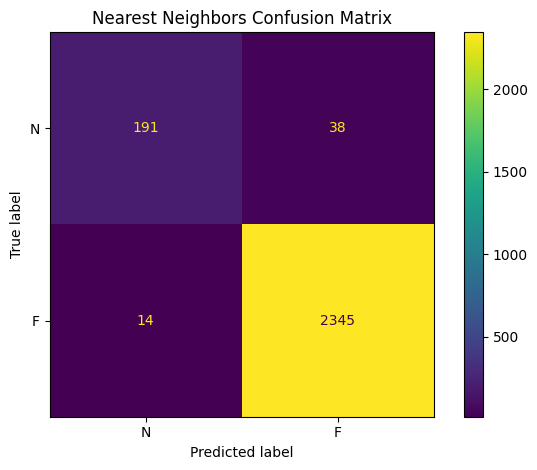

Training Linear SVM...
Score of Linear SVM is: 0.9165378670788253
Classification Report for Linear SVM:
              precision    recall  f1-score   support

           N       0.71      0.10      0.17       229
           F       0.92      1.00      0.96      2359

    accuracy                           0.92      2588
   macro avg       0.81      0.55      0.56      2588
weighted avg       0.90      0.92      0.89      2588



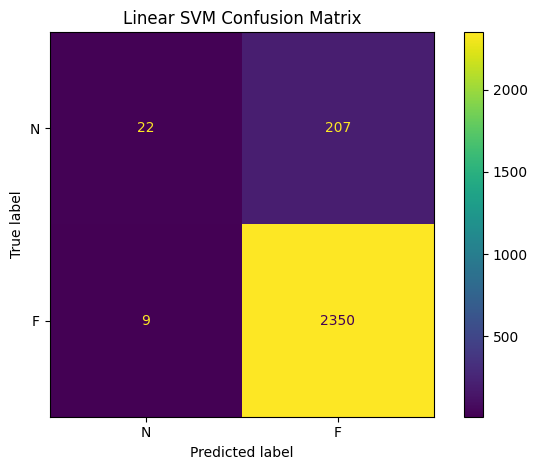

Training RBF SVM...
Score of RBF SVM is: 0.98145285935085
Classification Report for RBF SVM:
              precision    recall  f1-score   support

           N       0.95      0.83      0.89       229
           F       0.98      1.00      0.99      2359

    accuracy                           0.98      2588
   macro avg       0.97      0.91      0.94      2588
weighted avg       0.98      0.98      0.98      2588



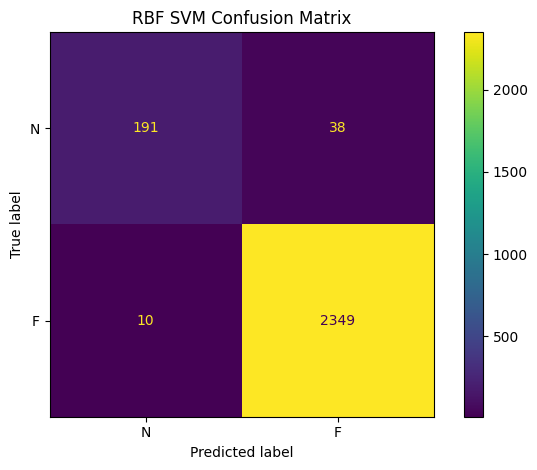

Training Decision Tree...
Score of Decision Tree is: 0.9829984544049459
Classification Report for Decision Tree:
              precision    recall  f1-score   support

           N       0.94      0.86      0.90       229
           F       0.99      0.99      0.99      2359

    accuracy                           0.98      2588
   macro avg       0.96      0.93      0.95      2588
weighted avg       0.98      0.98      0.98      2588



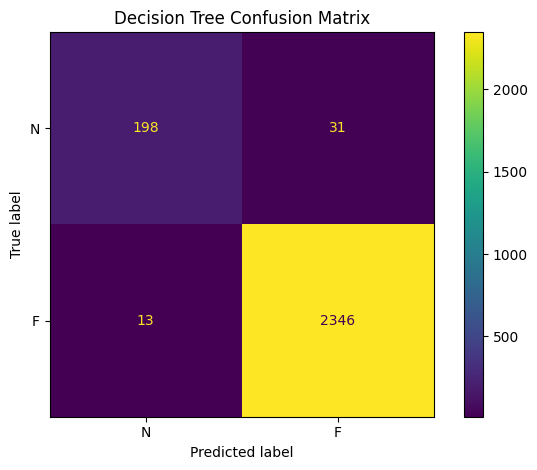

Training Random Forest...
Score of Random Forest is: 0.9806800618238022
Classification Report for Random Forest:
              precision    recall  f1-score   support

           N       0.92      0.86      0.89       229
           F       0.99      0.99      0.99      2359

    accuracy                           0.98      2588
   macro avg       0.95      0.92      0.94      2588
weighted avg       0.98      0.98      0.98      2588



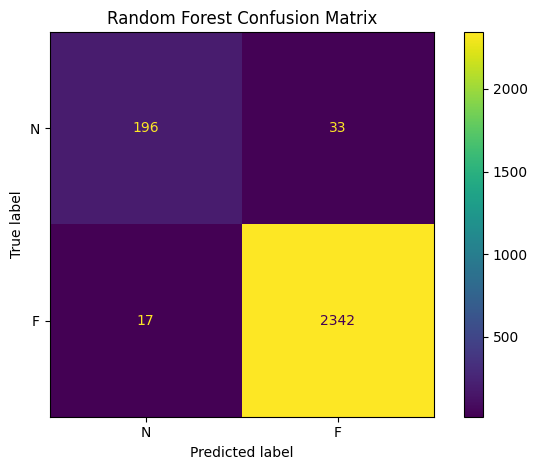

Training Neural Net...
Score of Neural Net is: 0.9567233384853169
Classification Report for Neural Net:
              precision    recall  f1-score   support

           N       0.83      0.65      0.73       229
           F       0.97      0.99      0.98      2359

    accuracy                           0.96      2588
   macro avg       0.90      0.82      0.85      2588
weighted avg       0.95      0.96      0.95      2588



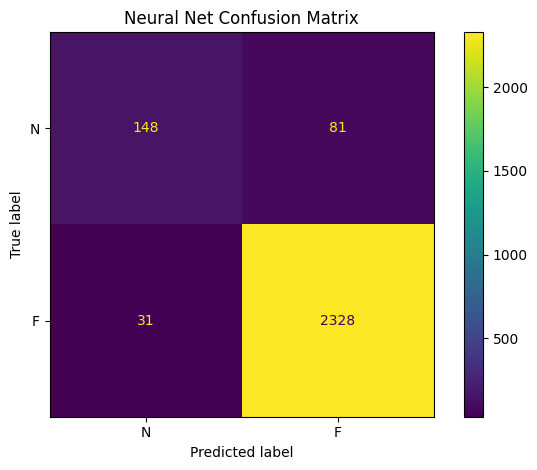

Training AdaBoost...
Score of AdaBoost is: 0.982612055641422
Classification Report for AdaBoost:
              precision    recall  f1-score   support

           N       0.93      0.87      0.90       229
           F       0.99      0.99      0.99      2359

    accuracy                           0.98      2588
   macro avg       0.96      0.93      0.94      2588
weighted avg       0.98      0.98      0.98      2588



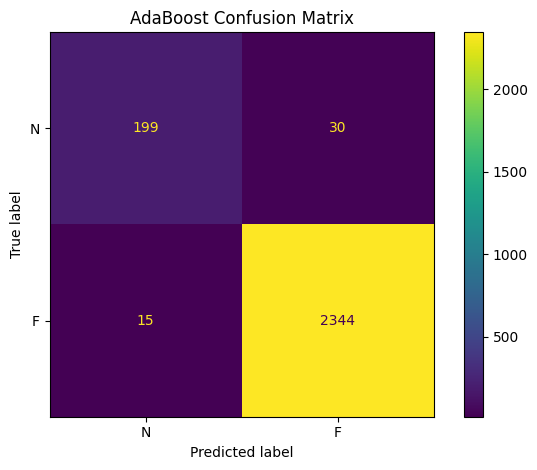

Training Naive Bayes...
Score of Naive Bayes is: 0.9211746522411128
Classification Report for Naive Bayes:
              precision    recall  f1-score   support

           N       0.56      0.55      0.55       229
           F       0.96      0.96      0.96      2359

    accuracy                           0.92      2588
   macro avg       0.76      0.75      0.75      2588
weighted avg       0.92      0.92      0.92      2588



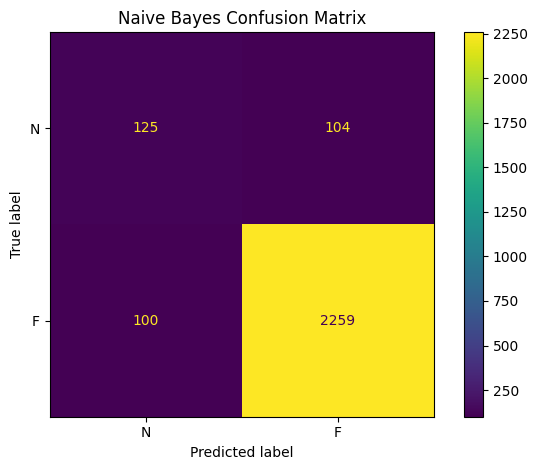

Training QDA...
Score of QDA is: 0.9663833075734157
Classification Report for QDA:
              precision    recall  f1-score   support

           N       0.83      0.78      0.80       229
           F       0.98      0.98      0.98      2359

    accuracy                           0.97      2588
   macro avg       0.90      0.88      0.89      2588
weighted avg       0.97      0.97      0.97      2588



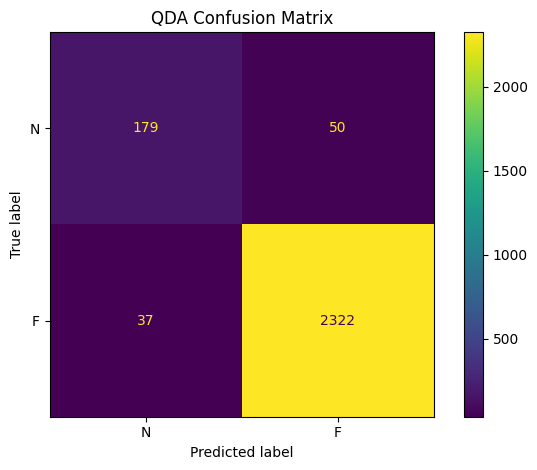

Training XGBoost...
Score of XGBoost is: 0.9899536321483772
Classification Report for XGBoost:
              precision    recall  f1-score   support

           N       0.97      0.92      0.94       229
           F       0.99      1.00      0.99      2359

    accuracy                           0.99      2588
   macro avg       0.98      0.96      0.97      2588
weighted avg       0.99      0.99      0.99      2588



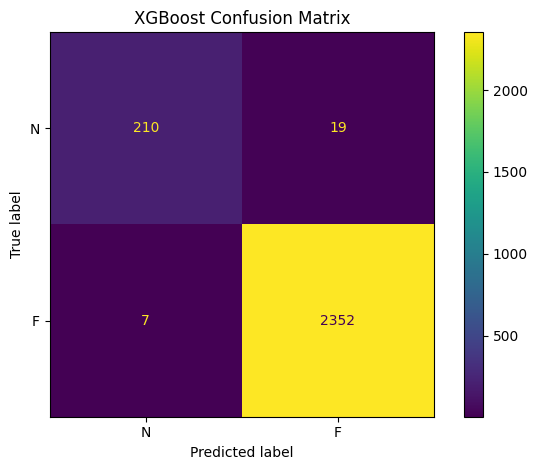

Training CatGBoost...
Score of CatGBoost is: 0.9922720247295209
Classification Report for CatGBoost:
              precision    recall  f1-score   support

           N       0.99      0.93      0.95       229
           F       0.99      1.00      1.00      2359

    accuracy                           0.99      2588
   macro avg       0.99      0.96      0.98      2588
weighted avg       0.99      0.99      0.99      2588



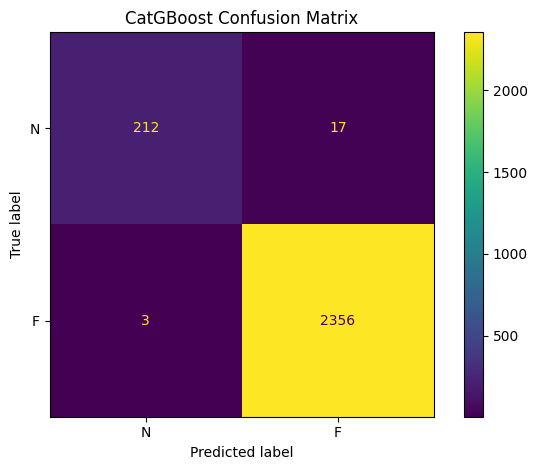

Training LightGBoost...
[LightGBM] [Info] Number of positive: 5414, number of negative: 622
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 1.365129 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3060
[LightGBM] [Info] Number of data points in the train set: 6036, number of used features: 12
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.896952 -> initscore=2.163803
[LightGBM] [Info] Start training from score 2.163803
Score of LightGBoost is: 0.991499227202473
Classification Report for LightGBoost:
              precision    recall  f1-score   support

           N       0.98      0.92      0.95       229
           F       0.99      1.00      1.00      2359

    accuracy                           0.99      2588
   macro avg       0.99      0.96      0.97      2588
weighted avg       0.99      0.99      0.99      2588



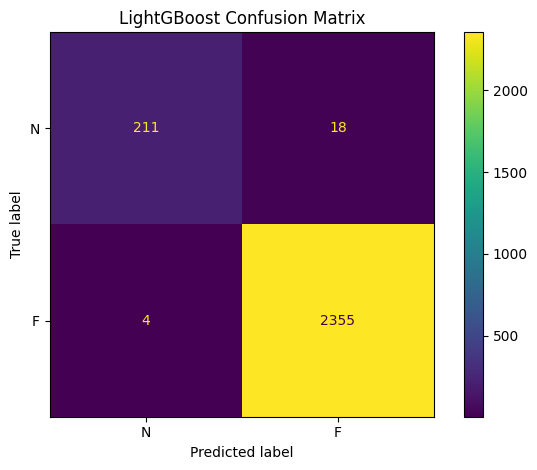

           Model Name  Accuracy
10          CatGBoost  0.992272
11        LightGBoost  0.991499
9             XGBoost  0.989954
3       Decision Tree  0.982998
6            AdaBoost  0.982612
2             RBF SVM  0.981453
4       Random Forest  0.980680
0   Nearest Neighbors  0.979907
8                 QDA  0.966383
5          Neural Net  0.956723
7         Naive Bayes  0.921175
1          Linear SVM  0.916538


In [36]:
names = ["Nearest Neighbors", "Linear SVM", "RBF SVM",
         #"Gaussian Process",
         "Decision Tree", "Random Forest", "Neural Net", "AdaBoost",
         "Naive Bayes", "QDA","XGBoost","CatGBoost","LightGBoost"]

classifiers = [
    KNeighborsClassifier(3),
    SVC(kernel="linear", C=0.025),
    SVC(gamma=2, C=1),
    #GaussianProcessClassifier(1.0 * RBF(1.0)),
    DecisionTreeClassifier(max_depth=5),
    RandomForestClassifier(max_depth=5, n_estimators=10, max_features=1),
    MLPClassifier(alpha=1, max_iter=1000),
    AdaBoostClassifier(),
    GaussianNB(),
    QuadraticDiscriminantAnalysis(),
    xgb.XGBClassifier(),
    cb.CatBoostClassifier(verbose = False),
    lgbm.LGBMClassifier()
    ]

# Lists to store results
scores = []

for name, clf in zip(names, classifiers):
    print("Training " + name + "...")

    clf.fit(X_x_train, y_train) # Train model
    predicted_labels = clf.predict(X_x_test)
    score = clf.score(X_x_test, y_test)
    labels = ['N', 'F']
    
    scores.append(score)

    print('Score of ' + name + ' is: ' + str(score))
    print('Classification Report for ' + name + ':')
    print(classification_report(y_test, predicted_labels, target_names=labels))
    #cm = confusion_matrix(y_test, predicted_labels)
    #cm_display = ConfusionMatrixDisplay(cm, display_labels=labels).plot()

    cm = confusion_matrix(y_test, predicted_labels)
    fig, ax = plt.subplots()
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
    disp.plot(ax=ax)
    ax.set_title(name + " Confusion Matrix")
    plt.tight_layout()  # Add spacing between plots
    plt.show()

#     plt.show()

# Create a DataFrame and sort by R2 Score in descending order
results_df = pd.DataFrame(list(zip(names, scores)), columns=['Model Name', 'Accuracy']).sort_values(by=["Accuracy"], ascending=False)

print(results_df)      

In [ ]:



        rf_params = {
            'n_estimators': trial.suggest_int("n_estimators", 1000, 8000),
            'max_depth': trial.suggest_int("max_depth", 2, 10),
            'min_samples_split': trial.suggest_int("min_samples_split", 2, 20),
            'min_samples_leaf': trial.suggest_int("min_samples_leaf", 1, 20),
            'max_features': trial.suggest_float("max_features", 0.2, 1.0),
            'random_state': 42
        }
        logreg_params = {
            'C': trial.suggest_float("C", 1e-3, 1e3, log=True),
            'solver': trial.suggest_categorical("solver", ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga']),
            'penalty': trial.suggest_categorical("penalty", ['none', 'l1', 'l2', 'elasticnet']),
            'random_state': 42
        }
        svm_params = {
            'C': trial.suggest_float("C", 1e-3, 1e3, log=True),
            'kernel': trial.suggest_categorical("kernel", ['linear', 'poly', 'rbf', 'sigmoid']),
            'gamma': trial.suggest_float("gamma", 1e-4, 1e1, log=True),
            'random_state': 42
        }
        xgb_params = {
            'max_depth': trial.suggest_int("max_depth", 2, 10),
            'learning_rate': trial.suggest_float("learning_rate", 1e-4, 1e-1, log=True),
            'n_estimators': trial.suggest_int("n_estimators", 1000, 8000),
            'min_child_weight': trial.suggest_int("min_child_weight", 1, 10),
            'colsample_bytree': trial.suggest_float("colsample_bytree", 0.2, 1.0),
            'subsample': trial.suggest_float("subsample", 0.2, 1.0),
            'reg_alpha': trial.suggest_float("reg_alpha", 1e-4, 1e2, log=True),
            'reg_lambda': trial.suggest_float("reg_lambda", 1e-4, 1e2, log=True),
        }
        clf = xgb.XGBClassifier(booster='gbtree', tree_method='hist', use_label_encoder=False, **xgb_params)

    clf.fit(X_train, y_train)
    preds = clf.predict(X_test)
    return accuracy_score(y_test, preds)

# Your data: X_train, y_train, X_test, y_test

study = optuna.create_study(direction="maximize")

# Optimize Random Forest
study.optimize(lambda trial: objective(trial, 'random_forest'), n_trials=20)
best_rf_params = study.best_params

# Optimize Logistic Regression
study.optimize(lambda trial: objective(trial, 'logistic_regression'), n_trials=20)
best_logreg_params = study.best_params

# Optimize SVM
study.optimize(lambda trial: objective(trial, 'svm'), n_trials=20)
best_svm_params = study.best_params

# Optimize XGBoost
study.optimize(lambda trial: objective(trial, 'xgboost'), n_trials=20)
best_xgb_params = study.best_params


**Hyperparameter Tuning**
Since accuracy score of the last 3 base model, namely XGBoost, CatBoost, LightBoost, are the highest ones, we will continue with one of them in further investigations.
Parameters of the selected model will be tuned with optuna library
Typical values were given as interval of parameters.

The purpose of the given function is to define an objective function for optimizing hyperparameters using Optuna for an XGBoost classifier. The code then uses Optuna to create a study for hyperparameter optimization with the direction of maximizing accuracy. The optimize method runs the objective function for a specified number of trials (in this case, 20) with different hyperparameter configurations.

After the optimization process is complete, the best set of hyperparameters found during the study is obtained using study.best_params. The study.best_params will give the hyperparameter configuration that resulted in the highest accuracy during the optimization process. These hyperparameters can be used to build the final XGBoost classifier for the given dataset.

In [37]:
def objective(trial):
    xgb_params = dict(
        max_depth=trial.suggest_int("max_depth", 2, 10),
        learning_rate=trial.suggest_float("learning_rate", 1e-4, 1e-1, log=True),
        n_estimators=trial.suggest_int("n_estimators", 1000, 8000),
        min_child_weight=trial.suggest_int("min_child_weight", 1, 10),
        colsample_bytree=trial.suggest_float("colsample_bytree", 0.2, 1.0),
        subsample=trial.suggest_float("subsample", 0.2, 1.0),
        reg_alpha=trial.suggest_float("reg_alpha", 1e-4, 1e2, log=True),
        reg_lambda=trial.suggest_float("reg_lambda", 1e-4, 1e2, log=True),
        )
    xgb_cl = xgb.XGBClassifier(
            booster='gbtree',
            tree_method ='hist',
            use_label_encoder=False,
            **xgb_params)
    xgb_cl.fit(X_x_train, y_train)
    preds = xgb_cl.predict(X_x_test)
    accuracy_score(y_test, preds)
    return accuracy_score(y_test,preds)

study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=20)
xgb_params = study.best_params

[I 2023-08-03 20:26:30,114] A new study created in memory with name: no-name-0fc96cb2-1fe5-4f1c-8572-8bbdbfd0a474


[I 2023-08-03 20:26:58,540] Trial 0 finished with value: 0.9636785162287481 and parameters: {'max_depth': 4, 'learning_rate': 0.0003123666989130855, 'n_estimators': 1133, 'min_child_weight': 6, 'colsample_bytree': 0.553531119085791, 'subsample': 0.6426131405746612, 'reg_alpha': 22.618254638566647, 'reg_lambda': 21.63395775465913}. Best is trial 0 with value: 0.9636785162287481.
[I 2023-08-03 20:29:55,800] Trial 1 finished with value: 0.9895672333848532 and parameters: {'max_depth': 6, 'learning_rate': 0.003625060839621674, 'n_estimators': 5023, 'min_child_weight': 4, 'colsample_bytree': 0.9437118497266379, 'subsample': 0.3811566771969747, 'reg_alpha': 0.010591035113296706, 'reg_lambda': 0.0028467332002882375}. Best is trial 1 with value: 0.9895672333848532.
[I 2023-08-03 20:32:15,233] Trial 2 finished with value: 0.9876352395672334 and parameters: {'max_depth': 5, 'learning_rate': 0.005036025702855785, 'n_estimators': 6361, 'min_child_weight': 8, 'colsample_bytree': 0.2575774922439725,

**Final XGBoost parameters were obtained by hyperparametertuning using GPU but final model should be trained by CPU to get possibly better result**

In [38]:
final_model = xgb.XGBClassifier(use_label_encoder=False,
                                **xgb_params)
final_model.fit(X_x_train, y_train)
preds = final_model.predict(X_x_test)
accuracy_score(y_test, preds)
#performance is increased

0.990340030911901